In [43]:
## import json
import numpy as np 
import tensorflow as tf
import json
np.random.seed(4)
from numpy import mean
from numpy import std

from tqdm import tqdm_notebook as tqdm
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import LSTM, Dense, BatchNormalization, Dropout


## fix random seed for reproducibility
np.random.seed(7)
max_seq_length=250
n_steps, n_length = 10,25
test_size = 0.2
verbose, epochs, batch_size = 0, 50, 350
num_conv_filter = 48
filter_size = (1,9)
min_det_threshold = 45


## Read the keypoint data from json and load into RAM

In [44]:
f = open('data.json',)
 
# returns JSON object as
# a dictionary
frame_data = json.load(f)


embedding_seq = []

cat = []

for i in range(len(frame_data["video_key_point"])):
    keypoint_seq = frame_data["video_key_point"][i]['filename']['keypoints']
    video_kpts = []
    for frame in keypoint_seq:
        collapsed = []
        
        for kpts in frame:
            # dist_from_origin = np.sqrt((kpts[0]**2)+(kpts[1]**2)+(kpts[2]**2))
            collapsed.append(kpts[0])
            collapsed.append(kpts[1])
            collapsed.append(kpts[2])
            # collapsed.append(dist_from_origin)
            
        video_kpts.append(np.array(collapsed))

    if len(video_kpts) > min_det_threshold:
        embedding_seq.append(np.array(video_kpts,dtype=np.float32))
        cat.append((frame_data["video_key_point"][i]['filename']['class']))


### There was an index bug while writing the Json

In [45]:
# accounting for a bug in the json writer 
category = []
base = -1
for i in cat:
    if i ==0:
        base +=1
    category.append(base) 
  

### Accounting for the data imbalance 


In [46]:
from matplotlib import pyplot as plt
from collections import Counter

class_counts_train = Counter(category)
print(class_counts_train)


# sample_weights for keras model
class_weights = np.array([1/i for i in class_counts_train.values()])
# class_weights[3], class_weights[4] = class_weights[3]*1.15, class_weights[4]*1.25 
print(class_weights)

Counter({2: 115, 1: 87, 0: 78, 3: 78, 4: 53})
[0.01282051 0.01149425 0.00869565 0.01282051 0.01886792]


In [47]:

category = np.array(category).reshape(-1,1)
enc = OneHotEncoder()
enc.fit(category)
onehotlabels = enc.transform(category).toarray()   

### One Hot Encoding for the target variable

In [48]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()

# 2. FIT
enc.fit(category)

# 3. Transform
onehotlabels = enc.transform(category).toarray()
onehotlabels.shape

(411, 5)

### Padding and Standard Scaling

In [49]:
# padding the embeddings
from sklearn.model_selection import train_test_split

sc = StandardScaler()


def load_dataset():

    X = sequence.pad_sequences(embedding_seq, maxlen=max_seq_length)
    X_scaled = sc.fit_transform(X.reshape(-1,X.shape[1]*X.shape[2]))
    X_scaled = X_scaled.reshape(X.shape)
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, onehotlabels ,test_size=test_size)

    return X_train, y_train, X_test, y_test

In [50]:
X_train, y_train, X_test, y_test = load_dataset()

print(f"x_train shape \t:\t{X_train.shape}\t y_train shape\t:\t{y_train.shape}")

print(f"x_test shape \t:\t{X_test.shape}\t y_test shape\t:\t{y_test.shape}")


x_train shape 	:	(328, 250, 99)	 y_train shape	:	(328, 5)
x_test shape 	:	(83, 250, 99)	 y_test shape	:	(83, 5)


### Defining the model

I have used ConvLSTM for the classification task. It has an accuracy slightly better than the LSTM.

In [51]:
def generate_sample_weights(training_data, class_weights): 
    sample_weights = [class_weights[np.where(one_hot_row==1)[0][0]] for one_hot_row in training_data]
    return np.asarray(sample_weights)


def plot_history(hist):
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    

In [52]:
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import SGD


def get_model(trainX, trainy, testX, testy):
    # define model
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    
    # reshape into subsequences (samples, time steps, rows, cols, channels)
    trainX = trainX.reshape((trainX.shape[0], n_steps, 1, n_length, n_features))
    testX = testX.reshape((testX.shape[0], n_steps, 1, n_length, n_features))

    
    # define model
    model = Sequential()
    model.add(ConvLSTM2D(filters=num_conv_filter, kernel_size=filter_size, activation='relu',
                         input_shape=(n_steps, 1, n_length, n_features),return_sequences = True))
    model.add(Dropout(0.5))
    
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.8))
    model.add(Dense(n_outputs, activation='softmax'))

#     opt = SGD(lr=0.01, momentum=0.9)
#   tf.keras.losses.CategoricalHinge()/
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
    # fit network
    hist = model.fit(trainX, trainy, epochs=epochs,validation_data=(testX, testy),
                     batch_size=batch_size, verbose=verbose,
                     sample_weight=generate_sample_weights(trainy, class_weights)
                    )
    
    plot_history(hist)
    _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
    y_pred = model.predict(testX)
        # evaluate model
    return  model, accuracy, y_pred, testy

In [53]:
import sklearn
def performance(y_pred, y_test):
    
    truth_argmax = np.argmax(y_test, axis=1)
    pred_argmax = np.argmax(y_pred, axis=1)
    
    test_cm = sklearn.metrics.confusion_matrix(truth_argmax, pred_argmax)
    test_f1 = sklearn.metrics.f1_score(truth_argmax, pred_argmax, average='macro')
    test_precision = sklearn.metrics.precision_score(truth_argmax, pred_argmax, average='macro')
    test_recall = sklearn.metrics.recall_score(truth_argmax, pred_argmax, average='macro')
    test_kappa = sklearn.metrics.cohen_kappa_score(truth_argmax, pred_argmax)

    test_f1_micro = sklearn.metrics.f1_score(truth_argmax, pred_argmax, average='micro')
    test_f1_weighted = sklearn.metrics.f1_score(truth_argmax, pred_argmax, average='weighted')
    
    print("Confusion Matrix:\n ", test_cm)
    print("F1 Score:\t", test_f1)
    print("F1 micro:\t", test_f1_micro)
    print("F1 weight:\t", test_f1_weighted)
    print("Precision:\t", test_precision)
    print("Recall:   \t", test_recall)

### Setting up cross validation pipeline 

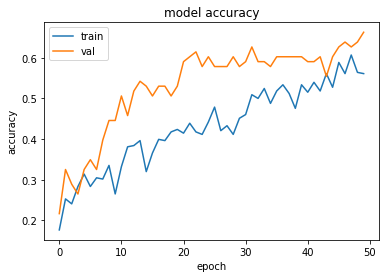

Best val-set accuracy so far: >#1: 66.265
Confusion Matrix:
  [[ 9  0  0  0  3]
 [ 2 14  1  1  6]
 [ 0  0 14  6  0]
 [ 0  1  4 13  1]
 [ 0  2  1  0  5]]
F1 Score:	 0.6533969600565571
F1 micro:	 0.6626506024096386
F1 weight:	 0.6738129612830963
Precision:	 0.6650089126559715
Recall:   	 0.6685087719298245


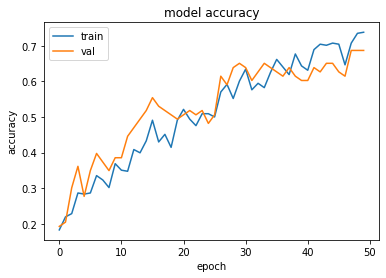

Best val-set accuracy so far: >#2: 68.675
Confusion Matrix:
  [[ 8  1  0  0  3]
 [ 2 14  0  1  7]
 [ 0  0 19  1  0]
 [ 0  1  4 12  2]
 [ 2  2  0  0  4]]
F1 Score:	 0.6555320648343904
F1 micro:	 0.6867469879518072
F1 weight:	 0.7007140613192729
Precision:	 0.6755348516218082
Recall:   	 0.6663157894736843


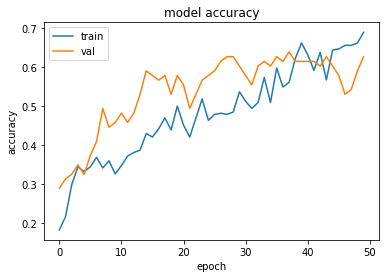

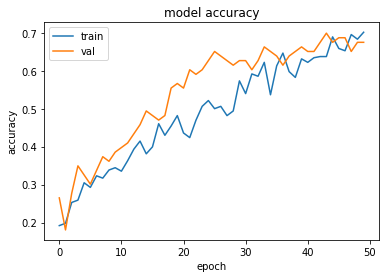

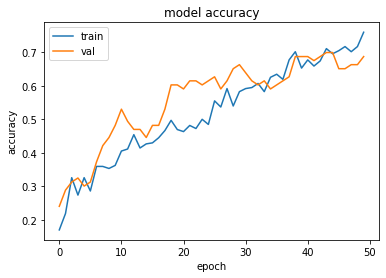

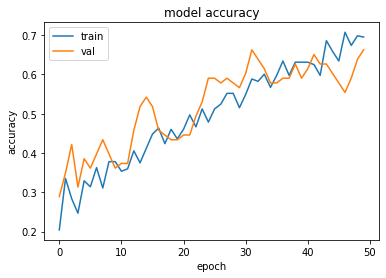

[66.26505851745605, 68.67470145225525, 62.65060305595398, 67.46987700462341, 68.67470145225525, 66.26505851745605]
Accuracy: 66.667% (+/-2.048)


In [54]:
def summarize_results(scores):
    print(scores)
    m, s = mean(scores), std(scores)
    print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))

def run_experiment(repeats=6):
    X_train, y_train, X_test, y_test = load_dataset()
    
    best_model = None
    best_acc = 0
    
    scores = list()
    for r in range(repeats):
        
        model, accuracy, y_pred, testy = get_model(X_train, y_train, X_test,y_test)
        score = accuracy * 100.0
        
        if score > best_acc:
            best_acc = score
            best_model = model
            
            print(f"Best val-set accuracy so far: {'>#%d: %.3f' % (r+1, score)}")
            performance(y_pred, testy)

        scores.append(score)

    summarize_results(scores)
    return best_model

# run the experiment
model = run_experiment()